In [1]:
import rockhound as rh
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pygplates
import pandas as pd
import pygmt
import cartopy.crs as ccrs

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


In [2]:
from rockhound.slab2 import ZONES

# Fetch all Slab2 subduction zones and add them inside a list
subduction_zones = []
for zone in ZONES:
    subduction_zones.append(rh.fetch_slab2(zone))

#merge into global
global_sub_zones = xr.merge([grid for grid in subduction_zones])

In [3]:
# Get min and max values of the subducting plates' depths
vmax = max([grid.depth.actual_range[1] for grid in subduction_zones])
vmin = min([grid.depth.actual_range[0] for grid in subduction_zones])

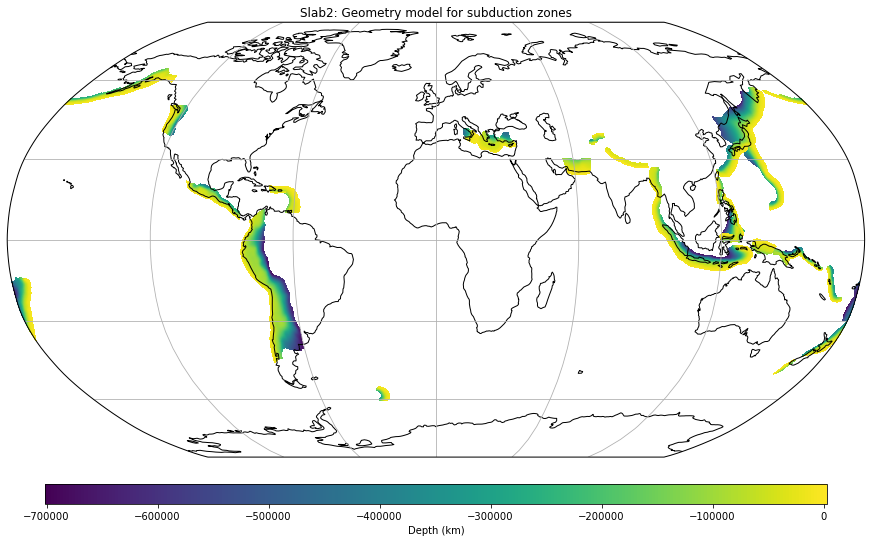

In [281]:
# Plot the depth of each subducting plate inside Slab2 with the same colorscale

plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.Robinson())
for grid in subduction_zones:
    pc = grid.depth.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        vmin=vmin,
        vmax=vmax
    )
    

ax.set_title("Slab2: Geometry model for subduction zones")
plt.colorbar(
    pc,
    ax=ax,
    label='Depth (km)',
    pad=0.05,
    aspect=40,
    shrink=0.7,
    orientation="horizontal",
)

ax.set_global()
ax.coastlines()
gl = ax.gridlines()
gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])

plt.show()

In [4]:
# now we want to make cross sections, but we have to load in individual grids (the global one
#isn't evenly sampled)
#our list of filenames are:
print(ZONES.keys())


dict_keys(['alaska', 'calabria', 'caribbean', 'cascadia', 'central_america', 'cotabalo', 'halmahera', 'hellenic', 'himalaya', 'hindu_kush', 'izu_bonin', 'kamchatka', 'kermadec', 'makran', 'manila_trench', 'muertos_trough', 'new_guinea', 'pamir', 'philippines', 'puysegur', 'ryukyu', 'scotia_sea', 'solomon_islands', 'south_america', 'sulawesi', 'sumatra_java', 'vanuatu'])


In [5]:
#Load sample grid and point datasets, use rockhound
SAM = rh.fetch_slab2('south_america')
IZB = rh.fetch_slab2('izu_bonin')
#get depth
grid = SAM.depth

In [6]:
#here we define our cross section, we have 40 points, some will returns nans though
#lat = [-25]*40
#lon = np.linspace(280, 300, 40)
#lat = [30]*40
#lon = np.linspace(160, 120, 40)
#pygmt track needs lon/lat as separate columns in pandas dataframe
d = { 'lon': lon,'lat': lat}
points = pd.DataFrame(data=d)

# Sample the sub zone using grdtrack. It returns a dataframe with a new column and the results
track = pygmt.grdtrack(points=points, grid=grid, newcolname='depth')

#define line for cross section
cross_section_points = []
cross_section_points.append((min(lat),min(lon)))
cross_section_points.append((max(lat),max(lon)))
cross_section_line = pygplates.PolylineOnSphere(cross_section_points)
cross_section_line = cross_section_line.to_tessellated(np.radians(0.1))

NameError: name 'lon' is not defined

In [ ]:
track

In [ ]:
#the df will contain some NaNs that we want to filtertrack
track_dropna = track.dropna()

In [ ]:
#use haversine formula to convert to km
#get distance, equally spaced so we can define at the start
lat1 = track_dropna['lat'].values[0]
lat2 = track_dropna['lat'].values[1]
lon1 = track_dropna['lon'].values[0]
lon2 = track_dropna['lon'].values[1]
# convert decimal degrees to radians 
lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

# haversine formula 
dlon = lon2 - lon1
dlat = lat2 - lat1 
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2

c = 2 * np.arcsin(np.sqrt(a)) 
r = 6371 # Radius of earth in kilometers. Use 3956 for miles

distance = c*r

#get the incremental range
distance_range = []
for i in range(track_dropna['depth'].count()):

    distance_range.append(i*distance)


In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(np.asarray(distance_range),
            track_dropna['depth'].values*.001)
plt.plot(np.asarray(distance_range),
            track_dropna['depth'].values*.001)
#plt.gca().set_xlim([0, 400])
#plt.gca().set_ylim([-200,0])
plt.xlabel('Distance from trench (km)')
plt.ylabel('Depth (km)')
plt.grid()

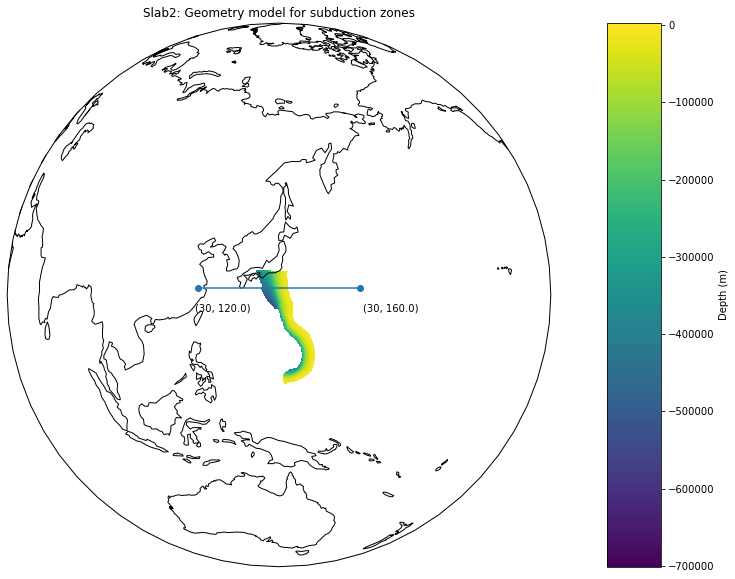

In [370]:
#plot cross section map
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=np.mean(lon), central_latitude=np.mean(lat)))
#grid = grid * -0.001
pc = grid.plot.pcolormesh(ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        vmin=vmin,
        vmax=vmax)
ax.set_title("Slab2: Geometry model for subduction zones")
plt.colorbar(
    pc,
    ax=ax,
    label='Depth (m)',
    pad=0.05,
    aspect=10,
    shrink=1,
    orientation="vertical",
)

ax.scatter([min(lon), max(lon)],
           [min(lat), max(lat)],transform=ccrs.PlateCarree())
ax.plot([min(lon), max(lon)],
        [min(lat), max(lat)],transform=ccrs.PlateCarree())
point_one = (min(lat), min(lon))
point_two = (max(lat), max(lon))
ax.text(min(lon), min(lat)-5, str(point_one),transform=ccrs.PlateCarree())
ax.text(max(lon), max(lat)-5, str(point_two),transform=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.grid()
plt.show()

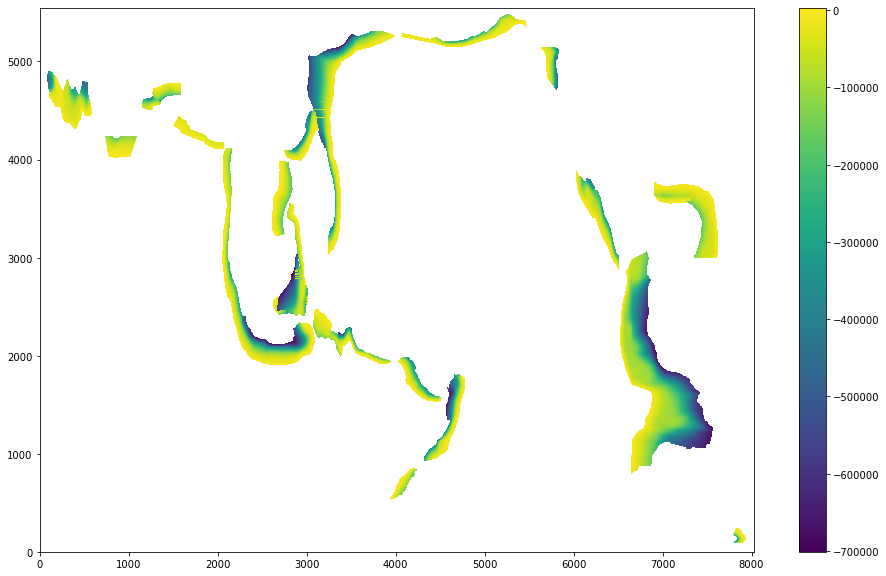

In [7]:
plt.figure(figsize=(16,10))
plt.pcolormesh(global_sub_zones.depth.values)
plt.colorbar()

In [16]:
lats = np.arange(-90,90.05,0.05)
lons = np.arange(0,360.1,0.1)
lons_mesh,lats_mesh = np.meshgrid(lons,lats)
nans = np.zeros_like(lons_mesh)
nans[:] = np.nan

In [17]:
nans

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [18]:
global_sub_zones

<xarray.Dataset>
Dimensions:            (latitude: 5543, longitude: 8027)
Coordinates:
  * latitude           (latitude) float64 -65.0 -64.95 -64.9 ... 67.9 67.95 68.0
  * longitude          (longitude) float64 8.0 8.05 8.1 ... 340.9 340.9 341.0
Data variables:
    depth              (latitude, longitude) float32 nan nan nan ... nan nan nan
    dip                (latitude, longitude) float32 nan nan nan ... nan nan nan
    strike             (latitude, longitude) float32 nan nan nan ... nan nan nan
    thickness          (latitude, longitude) float32 nan nan nan ... nan nan nan
    depth_uncertainty  (latitude, longitude) float32 nan nan nan ... nan nan nan

In [24]:
global_array = xr.Dataset(
                data_vars={'depth': (('latitude', 'longitude'), nans),
                           'dip': (('latitude', 'longitude'), nans),
                           'strike': (('latitude', 'longitude'), nans),
                           'thickness': (('latitude', 'longitude'), nans),
                           'depth_uncertainty': (('latitude', 'longitude'), nans)},
                coords={'latitude': lats,
                        'longitude': lons})

In [27]:
global_sub_zones = xr.merge([global_sub_zones, global_array])


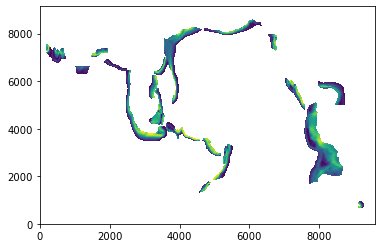

In [29]:
plt.pcolormesh(global_sub_zones.dip)

In [33]:
savefile = '/Users/Andrew/Documents/PhD/Scripts/Scripts_Input/slab_warping'
global_sub_zones.to_netcdf('%s/sub_zones_Slab2.nc' % savefile)